# Residential Rooftop PV Example

## Set up.

### One only needs to execute the following line once, in order to make sure recent enough packages are installed.

In [ ]:
#!pip install 'numpy>=1.17.2' 'pandas>=0.25.1'

### Import packages.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("../src"))

In [2]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import re                as re
import scipy.stats       as st
import seaborn           as sb

# The `tyche` package is located at <https://github.com/NREL/portfolio/tree/master/production-function/framework/src/tyche/>.
import tyche             as ty

from copy import deepcopy

## Scenario analyses.

### Load data.

#### The data are stored in a set of tab-separated value files in a folder.

In [3]:
designs = ty.Designs("../data/residential_pv")

#### Compile the production and metric functions for each technology in the dataset.

In [4]:
designs.compile()

### Examine the data.

#### The `functions` table specifies where the Python code for each technology resides.

In [5]:
designs.functions

,Style,Module,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
Residential PV,numpy,residential_pv,capital_cost,fixed_cost,production,metrics,


Right now, only the style `numpy` is supported.

#### The `indices` table defines the subscripts for variables.

In [6]:
designs.indices.sort_values(["Technology", "Type", "Offset"])

Offset               Description Notes
Technology     Type    Index                                              
Residential PV Capital Module            0             system module      
                       Inverter          1          system inverters      
                       BoS               2         balance of system      
               Fixed   System            0              whole system      
               Input   NaN               0                 no inputs      
               Metric  LCOE              0  levelized cost of energy      
               Output  Electricity       0     electricity generated

#### The `designs` table contains the cost, input, efficiency, and price data for a scenario.

In [7]:
designs.designs.xs("2015 Actual", level="Scenario", drop_level=False)

Value  \
Technology     Scenario    Variable          Index               
Residential PV 2015 Actual Input             NaN             0   
                           Input efficiency  NaN             1   
                           Input price       NaN             0   
                           Lifetime          BoS             1   
                                             Inverter        1   
                                             Module          1   
                           Output efficiency Electricity     1   
                           Output price      Electricity     0   
                           Scale             NaN             1   

                                                                    Units  \
Technology     Scenario    Variable          Index                          
Residential PV 2015 Actual Input             NaN                        1   
                           Input efficiency  NaN                        1   
                           Input price       NaN                        1   
                           Lifetime          BoS          system-lifetime   
                                             Inverter     system-lifetime   
                                             Module       system-lifetime   
                           Output efficiency Electricity              W/W   
                           Output price      Electricity            $/kWh   
                           Scale             NaN            system/system   

                                                                                                    Notes  
Technology     Scenario    Variable          Index                                                         
Residential PV 2015 Actual Input             NaN                                                no inputs  
                           Input efficiency  NaN                                                no inputs  
                           Input price       NaN                                                no inputs  
                           Lifetime          BoS                                per-lifetime computations  
                                             Inverter                           per-lifetime computations  
                                             Module                             per-lifetime computations  
                           Output efficiency Electricity  see parameter table for individual efficiencies  
                           Output price      Electricity                   not tracking electricity price  
                           Scale             NaN                                               no scaling

#### The `parameters` table contains additional techno-economic parameters for each technology.

In [8]:
designs.parameters.xs("2015 Actual", level="Scenario", drop_level=False).sort_values(["Technology", "Scenario", "Offset"])

Offset  \
Technology     Scenario    Parameter                             
Residential PV 2015 Actual Discount Rate                     0   
                           Insolation                        1   
                           System Size                       2   
                           Module Capital                    3   
                           Module Lifetime                   4   
                           Module Efficiency                 5   
                           Module Aperture                   6   
                           Module O&M Fixed                  7   
                           Module Degradation                8   
                           Location Capacity Factor          9   
                           Module Soiling Loss              10   
                           Inverter Capital                 11   
                           Inverter Lifetime                12   
                           Inverter Replacement             13   
                           Inverter Efficiency              14   
                           DC-to-AC Ratio                   15   
                           Hardware Capital                 16   
                           Direct Labor                     17   
                           Permitting                       18   
                           Customer Acquisition             19   
                           Installer Overhead & Profit      20   

                                                                                           Value  \
Technology     Scenario    Parameter                                                               
Residential PV 2015 Actual Discount Rate                                                    0.07   
                           Insolation                                                       1000   
                           System Size                                                        36   
                           Module Capital                    st.triang(0.5, loc=110, scale=0.11)   
                           Module Lifetime                  st.triang(0.5, loc=25, scale=0.0025)   
                           Module Efficiency              st.triang(0.5, loc=0.16, scale=1.6e-5)   
                           Module Aperture                   st.triang(0.5, loc=0.9, scale=9e-5)   
                           Module O&M Fixed                  st.triang(0.5, loc=20, scale=0.002)   
                           Module Degradation           st.triang(0.5, loc=0.0075, scale=7.5e-7)   
                           Location Capacity Factor          st.triang(0.5, loc=0.2, scale=2e-5)   
                           Module Soiling Loss              st.triang(0.5, loc=0.05, scale=5e-6)   
                           Inverter Capital                  st.triang(0.5, loc=0.3, scale=3e-5)   
                           Inverter Lifetime                st.triang(0.5, loc=16, scale=0.0016)   
                           Inverter Replacement              st.triang(0.5, loc=0.5, scale=5e-5)   
                           Inverter Efficiency               st.triang(0.5, loc=0.9, scale=9e-5)   
                           DC-to-AC Ratio                 st.triang(0.5, loc=1.4, scale=0.00014)   
                           Hardware Capital                  st.triang(0.5, loc=80, scale=0.008)   
                           Direct Labor                      st.triang(0.5, loc=2000, scale=0.2)   
                           Permitting                        st.triang(0.5, loc=600, scale=0.06)   
                           Customer Acquisition              st.triang(0.5, loc=2000, scale=0.2)   
                           Installer Overhead & Profit    st.triang(0.5, loc=0.35, scale=3.5e-5)   

                                                           Units Notes  
Technology     Scenario    Parameter                                    
Residential PV 2015 Actual Discount Rate                  1/year    DR  
                 

#### The `results` table specifies the units of measure for results of computations.

In [9]:
designs.results

Units Notes
Technology     Variable Index                      
Residential PV Cost     Cost         $/system      
               Metric   LCOE            $/kWh      
               Output   Electricity       kWh

#### Here is the source code for the computations.

In [10]:
!cat ../src/technology/residential_pv.py

# Residential PV

# All of the computations must be vectorized, so use `numpy`.
import numpy as np


# Discount at a rate for a time.
def discount(rate, time):
  return 1 / (1 + rate)**time


# Net present value of constant cash flow.
def npv(rate, time):
  return (1 - 1 / (1 + rate)**(time + 1)) / (1 - 1 / (1 + rate))


# Capital-cost function.
def capital_cost(scale, parameter):

  # For readability, copy the parameter vectors to named variables.
  dr  = parameter[ 0]
  ins = parameter[ 1]
  ssz = parameter[ 2]
  mcc = parameter[ 3]
  mlt = parameter[ 4]
  mef = parameter[ 5]
  icc = parameter[11]
  ilt = parameter[12]
  irc = parameter[13]
  bcc = parameter[16]
  blr = parameter[17]
  bpr = parameter[18]
  bca = parameter[19]
  boh = parameter[20]

  # System module capital cost. 
  smcxa = ssz * mcc 

  # System inverter capital cost.
  sicxa = ins * ssz * mef * icc

  # One inverter replacement.
  rsicxa1 = (mlt > ilt) * (mlt < 2 * ilt) * \
            (discount(dr, ilt) - (2 * il

### Evaluate the scenarios in the dataset.

In [11]:
scenario_results = designs.evaluate_scenarios(sample_count=500)

In [12]:
scenario_results

Value  \
Technology     Scenario    Sample Variable Index                        
Residential PV 2015 Actual 1      Cost     Cost          19537.416166   
                                  Metric   LCOE              0.106118   
                                  Output   Electricity  184110.179812   
                           2      Cost     Cost          19539.145448   
                                  Metric   LCOE              0.106125   
...                                                               ...   
               Expert C    499    Metric   LCOE              0.049980   
                                  Output   Electricity  292615.533400   
                           500    Cost     Cost          14645.735937   
                                  Metric   LCOE              0.049193   
                                  Output   Electricity  297720.342805   

                                                           Units  
Technology     Scenario    Sample Variable Index                  
Residential PV 2015 Actual 1      Cost     Cost         $/system  
                                  Metric   LCOE            $/kWh  
                                  Output   Electricity       kWh  
                           2      Cost     Cost         $/system  
                                  Metric   LCOE            $/kWh  
...                                                          ...  
               Expert C    499    Metric   LCOE            $/kWh  
                                  Output   Electricity       kWh  
                           500    Cost     Cost         $/system  
                                  Metric   LCOE            $/kWh  
                                  Output   Electricity       kWh  

[6000 rows x 2 columns]

#### Plot the results.

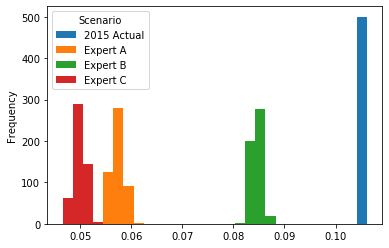

In [13]:
expert_results = scenario_results[["Value"]].xs(
    "LCOE", level="Index"
).rename(
    columns={"Value" : "LCOE [$/kWh]"}
).unstack(
    ["Scenario"]
).xs("LCOE [$/kWh]", axis=1, drop_level=True).reset_index(drop=True)
expert_results.plot.hist(bins=30)

### Make tornado plots for Expert A.

#### Remember base case LCOE.

In [14]:
base_lcoe = scenario_results.xs(["2015 Actual", "LCOE"], level=["Scenario", "Index"])[["Value"]].agg(np.mean)[0]
base_lcoe

0.10613269974604357

#### Define the factors.

In [15]:
tornado_factors = [
    "MCC", "MLT", "MEF", "MAP", "MOM",
    "MDR", "ICC", "ILT", "IRC", "IEF",
    "BCC", "BLR", "BPR", "BCA", "BOH",
]

#### Add the scenarios to the design.

In [16]:
design_2015_actual    = designs.designs.xs   ("2015 Actual", level="Scenario")
parameter_2015_actual = designs.parameters.xs("2015 Actual", level="Scenario")
parameter_expert_a    = designs.parameters.xs("Expert A"   , level="Scenario")
for factor in tornado_factors:
    scenario_new = factor
    design_new = design_2015_actual.copy()
    design_new["Scenario"] = scenario_new
    designs.designs = designs.designs.append(design_new.reset_index().set_index(["Technology", "Scenario", "Variable", "Index"]))
    parameter_new = pd.concat([
        parameter_2015_actual[parameter_2015_actual["Notes"] != factor],
        parameter_expert_a   [parameter_expert_a   ["Notes"] == factor],
    ])
    parameter_new["Scenario"] = factor
    designs.parameters = designs.parameters.append(parameter_new.reset_index().set_index(["Technology", "Scenario", "Parameter"]))

#### Recompile the design.

In [17]:
designs.compile()

#### Compute the results.

In [18]:
scenario_results = designs.evaluate_scenarios(sample_count=500)
scenario_results.shape

(28500, 2)

#### Make the tornado plot.

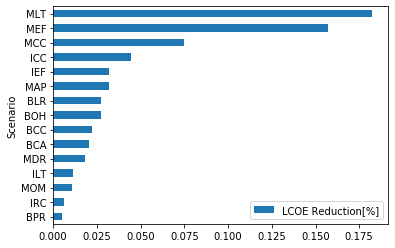

In [19]:
tornado_results = scenario_results[["Value"]].xs(
    "LCOE", level="Index"
).rename(
    columns={"Value" : "LCOE [$/kWh]"}
).reset_index(
    ["Technology", "Sample", "Variable"], drop=True
).groupby("Scenario").agg(np.min).drop(["2015 Actual", "Expert A", "Expert B", "Expert C"])
tornado_results["LCOE Reduction[%]"] = 1 - tornado_results["LCOE [$/kWh]"] / base_lcoe
tornado_results[["LCOE Reduction[%]"]].sort_values("LCOE Reduction[%]", ascending=True).plot.barh()

#### Look at the uncertainties.

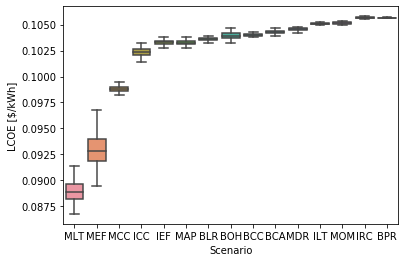

In [20]:
sb.boxplot(
    data = scenario_results[["Value"]].xs(
        "LCOE", level="Index"
    ).rename(
        columns={"Value" : "LCOE [$/kWh]"}
    ).reset_index(
        ["Technology", "Sample", "Variable"], drop=True
    ).drop(["2015 Actual", "Expert A", "Expert B", "Expert C"]).reset_index().sort_values("LCOE [$/kWh]"),
    x = "Scenario",
    y = "LCOE [$/kWh]"
)